# Implementing UNET for biomedical image segmentation
## Pt. 3 - UNET++
In this set of notebooks, I implement UNET for segmentation of biomedical images. Specifically, the kvasir-seg dataset which is comprised of colonoscopy images of polyps with matching masks made by doctors. This is important in identifying GI diseases, such as colorectal cancer, in their early stages.

I will be using pytorch for this set of notebooks (and my fancy new rtx 3060, since I've been having issues with being dropped from colab)

This notebook will be exploring the implementation of UNET++, which has shown some better results for biomedical imaging data. 

dataset: https://datasets.simula.no/kvasir-seg/

In [1]:
import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# check that a gpu is being used and its vram
dev = torch.cuda.current_device()
t = torch.cuda.get_device_properties(dev).total_memory
name = torch.cuda.get_device_name(dev)
availability = torch.cuda.is_available()
print(name, ":", round(t/ 1000000000,2), "GB VRAM")
print("cuda availability:", availability)

NVIDIA GeForce RTX 3060 : 12.88 GB VRAM
cuda availability: True


In [3]:
# allow tf32 operations for quicker maths
torch.backends.cudnn.allow_tf32 = True

Datasets made the same way as earlier notebooks.

In [4]:
root = 'D:\\tensorflow_datasets\\Kvasir-SEG'
testroot='D:\\tensorflow_datasets\\Kvasir-SEG\\test'
def make_dataset(root: str) -> list:
    """Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (img_path, mask_path)
    """
    dataset = []

    # Our dir names
    img_dir = 'images'
    mask_dir = 'masks'   
    
    # Get all the filenames from img folder
    img_fnames = sorted(os.listdir(os.path.join(root, img_dir)))
    
    # Compare file names from mask folder to file names from img:
    for mask_fname in sorted(os.listdir(os.path.join(root, mask_dir))):

            if mask_fname in img_fnames:
                # if we have a match - create pair of full path to the corresponding images
                img_path = os.path.join(root, img_dir, mask_fname)
                mask_path = os.path.join(root, mask_dir, mask_fname)

                item = (img_path, mask_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset

In [5]:
dataset = make_dataset(root)
print('Our dataset:')
print(*dataset, sep='\n')

Our dataset:
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qkwl35piu0993l0dewei2.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qkwl35piu0993l0dewei2.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qoxqj9q6s0835b43399p4.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qoxqj9q6s0835b43399p4.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qx73cjw570799j4n5cjze.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qx73cjw570799j4n5cjze.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0roawvklrq0799vmjorwfv.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0roawvklrq0799vmjorwfv.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0rx1idathl0835detmsp84.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0rx1idathl0835detmsp84.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0s2a9ekvms080138tjjpxr.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0s2a9ekvms080138tjjpxr.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0

In [6]:
test_dataset = make_dataset(testroot)
print('Our training dataset:')
print(*test_dataset, sep='\n')

Our training dataset:
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13cgqmnhwn0988yrainhcp.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13cgqmnhwn0988yrainhcp.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13fwthn9mq0835gacxgy01.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13fwthn9mq0835gacxgy01.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13hp5rnbjx0835bf0jowgx.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13hp5rnbjx0835bf0jowgx.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14g8o4xui30878gkgbrvqj.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju14g8o4xui30878gkgbrvqj.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14hjh2ob2o0835ouz3r5aa.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju14hjh2ob2o0835ouz3r5aa.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14pxbaoksp0835qzorx6g6.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cj

In [7]:
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset


class CustomVisionDataset(VisionDataset):
    
    def __init__(self,
                 root,
                 loader=default_loader,
                 img_transform=None,
                 mask_transform=None):
        super().__init__(root,
                         transform=img_transform,
                         target_transform=mask_transform)

        # Prepare dataset
        samples = make_dataset(self.root)

        self.loader = loader
        self.samples = samples
        # list of img images
        self.img_samples = [s[1] for s in samples]
        # list of mask images
        self.mask_samples = [s[1] for s in samples]

    def __getitem__(self, index):
        """Returns a data sample from our dataset.
        """
        # getting our paths to images
        img_path, mask_path = self.samples[index]
        
        # import each image using loader (by default it's PIL)
        img_sample = self.loader(img_path)
        mask_sample = self.loader(mask_path)
        
        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        if self.transform is not None:
            img_sample = self.transform(img_sample)
        if self.target_transform is not None:
            mask_sample = self.target_transform(mask_sample)      
        
        # now we return the right imported pair of images (tensors)
        return img_sample, mask_sample

    def __len__(self):
        return len(self.samples)



I was running out of memory with the batch size of 8 and had to decrease it to 2.

batch 1:
torch.Size([2, 1, 256, 320])
torch.Size([2, 1, 256, 320])


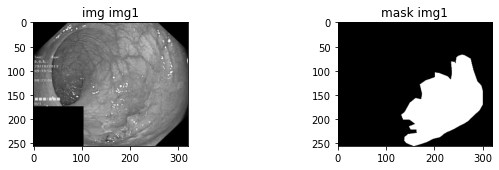

torch.Size([2, 1, 256, 320])
torch.Size([2, 1, 256, 320])


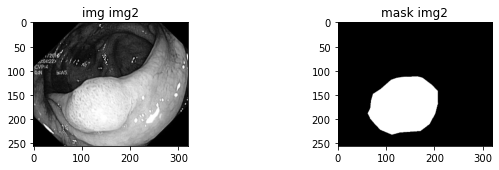

In [8]:
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Grayscale

import matplotlib.pyplot as plt


bs=2  # batch size
# convert PIL images to Tensor, make them all the same size, and make them grayscale
transforms = torchvision.transforms.Compose([ToTensor(),Resize((256, 320)),Grayscale(num_output_channels=1)])  
shuffle = True

dataset = CustomVisionDataset(root, img_transform=transforms, mask_transform=transforms)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)

test_dataset = CustomVisionDataset(testroot, img_transform=transforms, mask_transform=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=shuffle)

for i, (img, mask) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(bs):
        plt.figure(figsize=(10, 5))
        plt.subplot(221)
        print(img.size())
        plt.imshow(img[i].squeeze(),cmap='gray')
        plt.title(f'img img{i+1}')
        plt.subplot(222)
        print(mask.size())
        plt.imshow(mask[i].squeeze(),cmap='gray')
        plt.title(f'mask img{i+1}')
        plt.show()
    if i >= 0:
        break
        


How is UNET++ different? It has th following additions:
1. redesigned skip pathways 
2. dense skip connections 
3. deep supervision 

Now we will put it all together into a class:

In [9]:
class conv_block_nested(nn.Module):

    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class Nested_UNet(nn.Module):

    def __init__(self, in_ch=1, out_ch=1):
        super(Nested_UNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

    def forward(self, x):

        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

Now we can make our model. Then we will do a test run to see our input and output sizes and catch any errors before the full training loop

In [10]:
model = Nested_UNet()

if torch.cuda.is_available():
    model.cuda()

In [11]:
from torch.autograd import Variable

for i,(img,mask) in enumerate(dataloader):
    input_var = Variable(img.cuda())

    output = model(input_var).cuda()
    print("input size", input_var.size(),
          "output_size", output.size())
    if i>3:
        break

input size torch.Size([2, 1, 256, 320]) output_size torch.Size([2, 1, 256, 320])
input size torch.Size([2, 1, 256, 320]) output_size torch.Size([2, 1, 256, 320])
input size torch.Size([2, 1, 256, 320]) output_size torch.Size([2, 1, 256, 320])
input size torch.Size([2, 1, 256, 320]) output_size torch.Size([2, 1, 256, 320])
input size torch.Size([2, 1, 256, 320]) output_size torch.Size([2, 1, 256, 320])


We will now go on to training our model. We will use the same criterion and optimizer as before.

In [12]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay =0.1)
model.train()

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    losses=[]
    for i, (img, mask) in enumerate(dataloader): 
        img, mask = Variable(img.cuda()), Variable(mask.cuda())

        optimizer.zero_grad()

        outputs = model(img).cuda()
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

    print("BCE Loss:" , loss)
    losses.append([loss,epoch])
print('Finished Training')


BCE Loss: tensor(0.3483, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3511, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3284, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.5534, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.2589, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.2779, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.2735, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.2590, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3919, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: 

In [25]:
train_loss=[
0.3483,
0.3209,
0.3216,
0.3511,
0.3284,
0.5534,
0.2589,
0.2779,
0.2735,
0.2590,
0.3919,
0.5020,
0.3207,
0.2822,
0.3232,
0.2979,
0.2745,
0.2853,
0.3320,
0.2624,
0.3019,
0.3712,
0.3976,
0.2870,
0.3828,
0.4833,
0.2687,
0.5047,
0.3385,
0.2979,
0.3633,
0.4005,
0.2814,
0.3453,
0.3258,
0.5611,
0.3956,
0.4758,
0.3192,
0.4005,
0.3396,
0.5428,
0.4408,
0.3019,
0.3301,
0.5268,
0.3516,
0.4614,
0.3282,
0.2801]


Save the state dicts for future use

In [13]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

#torch.save(model.state_dict(), '/statedict')
#torch.save(optimizer.state_dict(), '/optstatedict')


Model's state_dict:
conv0_0.conv1.weight 	 torch.Size([64, 1, 3, 3])
conv0_0.conv1.bias 	 torch.Size([64])
conv0_0.bn1.weight 	 torch.Size([64])
conv0_0.bn1.bias 	 torch.Size([64])
conv0_0.bn1.running_mean 	 torch.Size([64])
conv0_0.bn1.running_var 	 torch.Size([64])
conv0_0.bn1.num_batches_tracked 	 torch.Size([])
conv0_0.conv2.weight 	 torch.Size([64, 64, 3, 3])
conv0_0.conv2.bias 	 torch.Size([64])
conv0_0.bn2.weight 	 torch.Size([64])
conv0_0.bn2.bias 	 torch.Size([64])
conv0_0.bn2.running_mean 	 torch.Size([64])
conv0_0.bn2.running_var 	 torch.Size([64])
conv0_0.bn2.num_batches_tracked 	 torch.Size([])
conv1_0.conv1.weight 	 torch.Size([128, 64, 3, 3])
conv1_0.conv1.bias 	 torch.Size([128])
conv1_0.bn1.weight 	 torch.Size([128])
conv1_0.bn1.bias 	 torch.Size([128])
conv1_0.bn1.running_mean 	 torch.Size([128])
conv1_0.bn1.running_var 	 torch.Size([128])
conv1_0.bn1.num_batches_tracked 	 torch.Size([])
conv1_0.conv2.weight 	 torch.Size([128, 128, 3, 3])
conv1_0.conv2.bias 	 torch.Si

In [17]:
model.eval()


for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    test_losses=[]
    for i, (img, mask) in enumerate(test_dataloader): 
        img, mask = Variable(img.cuda()), Variable(mask.cuda())
        with torch.no_grad():
            out_data = model(img).cuda()
            
    loss = criterion(outputs, mask)
    test_losses.append([loss,epoch])
    print("BCE Loss:" , loss)
print('Finished Training')

BCE Loss: tensor(0.3489, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.7069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4815, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3235, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3886, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3384, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4427, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4525, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: 

In [26]:
test_loss=[
0.3489,
0.4196,
0.7069,
0.4815,
0.3235,
0.3886,
0.3384,
0.3198,
0.4427,
0.4525,
0.5222,
0.3734,
0.6596,
0.4535,
0.6474,
0.4128,
0.3522,
0.3908,
0.3737,
0.2885,
0.4963,
0.2967,
0.4788,
0.4734,
0.4386,
0.4181,
0.3712,
0.3702,
0.4388,
0.5126,
0.4467,
0.3714,
0.3781,
0.3982,
0.5123,
0.4120,
0.3785,
0.3432,
0.3636,
0.4040,
0.6158,
0.4409,
0.3296,
0.4186,
0.4671,
0.5906,
0.8600,
0.6249,
0.4174,
0.4241]

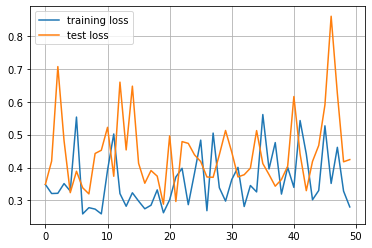

In [27]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.grid(True)
plt.legend(['training loss', 'test loss'])

Here we can see our loss for both training and validation. The model doesn't look to perform much better than the regular UNET, with the lowest test loss sitting at about the same as the 50 epoch UNET model. There was a uge spike in loss just before the end, so I'm wondering if I need more epochs. If so, I'll probably need to reduce image size since training the UNET++ currently took 2.5 hours. 

Now, let's look at a sample of our image, mask, and prediction.

batch 1:


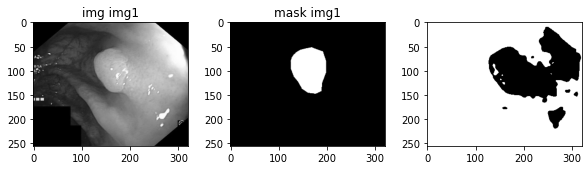

In [20]:

for i, (img, mask) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(1):
        plt.figure(figsize=(10, 5))
        plt.subplot(231)
        plt.imshow(img[i].squeeze(),cmap='gray')
        plt.title(f'img img{i+1}')
        plt.subplot(232)
        plt.imshow(mask[i].squeeze(),cmap='gray')
        plt.title(f'mask img{i+1}')
        
        pred_img = model(img.cuda()).cuda()
        pred_img = np.squeeze(pred_img.cpu().detach().permute(2, 3, 1,0))
        pred_img1 = pred_img[:, :, 0]
        pred_img2=pred_img1.numpy().astype(np.uint8)
        plt.subplot(233)
        plt.imshow(pred_img2,cmap='gray')
    if i >= 0:
        break

batch 1:


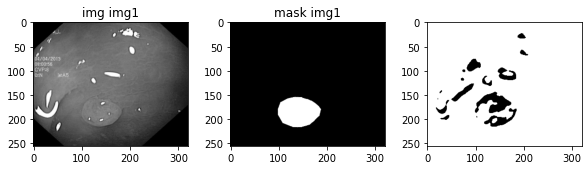

In [22]:
for i, (img, mask) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(1):
        plt.figure(figsize=(10, 5))
        plt.subplot(231)
        plt.imshow(img[i].squeeze(),cmap='gray')
        plt.title(f'img img{i+1}')
        plt.subplot(232)
        plt.imshow(mask[i].squeeze(),cmap='gray')
        plt.title(f'mask img{i+1}')
        
        pred_img = model(img.cuda()).cuda()
        pred_img = np.squeeze(pred_img.cpu().detach().permute(2, 3, 1,0))
        pred_img1 = pred_img[:, :, 0]
        pred_img2=pred_img1.numpy().astype(np.uint8)
        plt.subplot(233)
        plt.imshow(pred_img2,cmap='gray')
    if i >= 0:
        break

Our model seems to be highlighting the overexposed sections of the image along with the area of interest, and doesn't seem to be much better than our regular UNET model. Anothe thing to note is that the masking is inverted, which isn't too big of a deal but it is odd. This could also be due to how I converted the tensor back into an image, however. 